In [85]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [86]:
words = open('names.txt','r').read().splitlines()
words[:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

In [87]:
len(words)

32033

In [88]:
chars = sorted(list(set(''.join(words))))
stoi = {c:i+1 for i,c in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}

In [116]:
#build dataset
block_size = 3 # context length: how many chars do we take to predict the next one?
X, Y = [],[]
for w in words:
    #print(w)
    context = [0]*block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        #print(''.join(itos[i] for i in context),'--->',itos[ix])
        context = context[1:] + [ix]
X = torch.tensor(X)
Y = torch.tensor(Y)


In [117]:
X.shape,X.dtype,Y.shape,Y.dtype

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

In [199]:
def build_dataset(words):
    block_size = 3 # context length: how many chars do we take to predict the next one?
    X, Y = [],[]
    for w in words:
        #print(w)
        context = [0]*block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            #print(''.join(itos[i] for i in context),'--->',itos[ix])
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X,Y 

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))
Xtr,Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])


In [91]:
C = torch.randn((27,2))

In [92]:
emb = C[X]
emb.shape

torch.Size([32, 3, 2])

In [93]:
W1 = torch.randn((6, 100))
b1 = torch.randn(100)

In [94]:
h = torch.tanh(emb.view(-1,6) @ W1 + b1)
h.shape

torch.Size([32, 100])

In [95]:
b1.shape

torch.Size([100])

In [96]:
W2 = torch.randn((100,27))
b2 = torch.randn(27)

In [97]:
logits = h @ W2 + b2

In [98]:
logits.shape

torch.Size([32, 27])

In [99]:
counts = logits.exp()
prob = counts/ counts.sum(1,keepdims = True)

In [100]:
prob.shape

torch.Size([32, 27])

In [101]:
loss = -prob[torch.arange(32),Y].log().mean()
loss

tensor(19.1857)

In [102]:
#---- now made respectable ------

In [221]:
Xtr.shape, Ytr.shape

(torch.Size([182580, 3]), torch.Size([182580]))

In [265]:
g = torch.Generator().manual_seed(0)
C = torch.randn((27,10),generator=g)
W1 = torch.randn((30,200),generator=g)
b1 = torch.randn(200,generator = g)
W2 = torch.randn((200,27),generator=g)
b2 = torch.randn(27,generator=g) 
parameters = [C,W1,b1,W2,b2]

In [266]:
sum(p.nelement() for p in parameters) # number of parmaeters in total

11897

In [267]:
for p in parameters:
    p.requires_grad = True

In [268]:
lre = torch.linspace(-3,0,1000)
lrs = 10**lre


In [269]:
lri = []
lossi = []
stepi = []

In [270]:
#forward pass
for i in range(200000):
    #minibatch construct
    ix = torch.randint(0,Xtr.shape[0],(32,))
    emb = C[Xtr[ix]]
    h = torch.tanh(emb.view(-1,30)@W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits,Ytr[ix])  
    #print(loss.item())
    # backward
    for p in parameters:
        p.grad = None
    loss.backward()
    #update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr*p.grad
    
    #track stats
    # lri.append(lre[i])
    lossi.append(loss.log10().item())
    stepi.append(i)

print(loss.item())

1.896520972251892


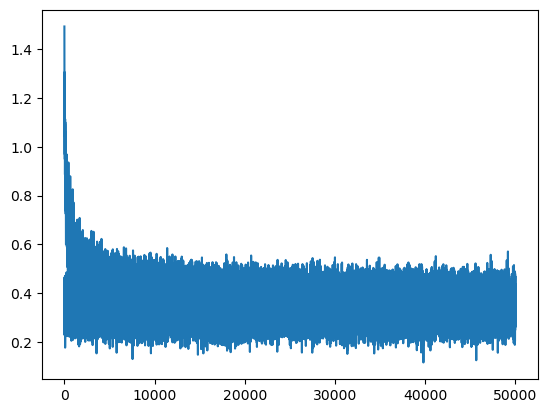

In [263]:
plt.plot(stepi,lossi)

In [264]:
emb = C[Xdev]
h = torch.tanh(emb.view(-1,30)@W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits,Ydev) 
loss

tensor(2.2191, grad_fn=<NllLossBackward0>)

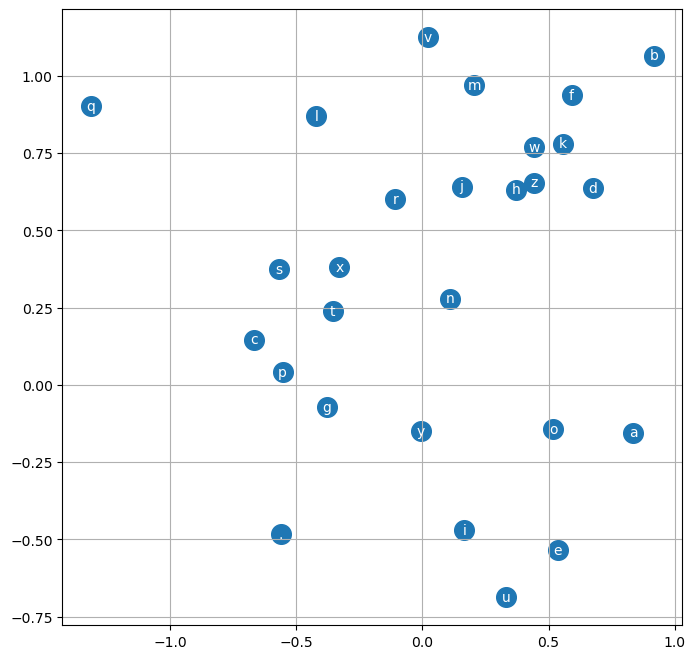

In [249]:
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data,s = 200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha ='center',va='center',color='white')
plt.grid('minor')

In [273]:
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

carlah.
ambrillif.
jari.
reh.
caspansen.
jazonte.
amerric.
kaquic.
ramara.
chaiin.
kaleigh.
ham.
joce.
quint.
shoisea.
jadiquinterra.
jarynn.
jacen.
dusti.
emmedi.
